## Replicate model in Preisler et al. (2017)

Their approach was to use a general additive model with a logit link function. GAMs are hard to implement in Python and do not play well with tensorflow. We will approximate this with a dense neural network with a logit activation function in the output node.

In [1]:
%%capture
pip install shap tensorboard xbatcher imbalanced-learn

In [2]:
import os

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

import util

Changed working directory to /home/jovyan/ForestLST


In [3]:
import util

import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import rioxarray
import cartopy.crs as ccrs

import shutil
import json
import random

### Get data

In [4]:
ds = xr.open_dataset("data_working/westmort.nc")
bounds = ds.rio.write_crs(3857).rio.bounds()

In [5]:
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

ds["mort_shift"] = ds["mort_ewma"].shift(time=1)

In [6]:
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

## Model definition

In [7]:
def make_simpledense(input_size, init_bias: float=None, dropout: float=0.2):
    m = torch.nn.Sequential(
        torch.nn.BatchNorm1d(input_size),
        torch.nn.Linear(input_size, 16),
        torch.nn.Dropout(p=dropout),
        torch.nn.Tanh(),
        torch.nn.Linear(16, 32),
        torch.nn.Dropout(p=dropout),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 8),
        torch.nn.Dropout(p=dropout),
        torch.nn.Tanh(),
        torch.nn.Linear(8, 1),
        torch.nn.Sigmoid()
    )

    if init_bias is not None:
        torch.nn.init.constant_(m[-2].bias, init_bias)

    return m

In [8]:
sd = make_simpledense(13, init_bias=1.0)
print(sd)

Sequential(
  (0): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=13, out_features=16, bias=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=32, bias=True)
  (5): Dropout(p=0.2, inplace=False)
  (6): Tanh()
  (7): Linear(in_features=32, out_features=8, bias=True)
  (8): Dropout(p=0.2, inplace=False)
  (9): Tanh()
  (10): Linear(in_features=8, out_features=1, bias=True)
  (11): Sigmoid()
)


### Convert inputs to tensors

In [9]:
list(ds.variables.keys())

['time',
 'x',
 'y',
 'abies',
 'picea',
 'populus',
 'pseudotsuga',
 'tsuga',
 'vod',
 'elev',
 'slope',
 'northness',
 'eastness',
 'fire',
 'mortality',
 'prcp',
 'vp',
 'tmin',
 'treecover',
 'spatial_ref',
 'mort_ewma',
 'mort_shift',
 'forest_ba']

In [10]:
TARGET = ["mort_shift"]
BANDS = ["forest_ba", "prcp", "vp", "tmin", "fire", "elev", "vod", "mort_ewma"]

df = ds[TARGET + BANDS].to_dataframe().dropna().reset_index()

In [11]:
print(df.shape)
df.head()

(871416, 12)


,y,x,time,mort_shift,forest_ba,prcp,vp,tmin,fire,elev,vod,mort_ewma
0,6274302.419,-1.360222e+07,2002,0.0,8.0,1410.0,1313.0,0.0,0.0,35.0,430.0,0.0
1,6274302.419,-1.360222e+07,2003,0.0,8.0,1102.0,1262.0,0.0,0.0,35.0,430.0,0.0
2,6274302.419,-1.360222e+07,2004,0.0,8.0,1505.0,1365.0,0.0,0.0,35.0,413.0,0.0
3,6274302.419,-1.360222e+07,2005,0.0,8.0,1545.0,1363.0,0.0,0.0,35.0,425.0,0.0
4,6274302.419,-1.360222e+07,2006,0.0,8.0,1255.0,1272.0,1.0,0.0,35.0,429.0,0.0


In [12]:
years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

train_df = df[df.time.isin(train_years)]
valid_df = df[df.time.isin(valid_years)]
test_df  = df[df.time.isin(test_years)]

print("N rows")
print(train_df.shape[0])
print(valid_df.shape[0])
print(test_df.shape[0])

N rows
311601
160389
399426


In [13]:
from torch.utils.data import TensorDataset, DataLoader

def df_to_dataloader(df):
    # Add two dimensions
    input = torch.from_numpy(df[BANDS].to_numpy().astype(np.float32))
    output = torch.from_numpy(df[TARGET].to_numpy().astype(np.float32))/100

    ds = TensorDataset(input, output)
    
    return DataLoader(ds, batch_size=512, shuffle=True)

train_dl = df_to_dataloader(train_df)
valid_dl = df_to_dataloader(valid_df)
test_dl  = df_to_dataloader(test_df)

### Training loop

In [14]:
from importlib import reload
reload(util.training)
from util.training import BaseTrainer, ReduceLRMixin, EarlyStopMixin

# Masked loss is very slow for some reason
class Trainer(ReduceLRMixin, EarlyStopMixin, BaseTrainer):
    pass

In [15]:
import torchmetrics

# Only doing temporal split since that makes the most
# sense here.
model_name = "031825_simpledense"

y_mean = train_df.mort_ewma.mean()/100
init_bias = np.log(y_mean / (1-y_mean))
n_feats = next(iter(train_dl))[0].shape[1]

model = make_simpledense(n_feats, dropout=0.5, init_bias=init_bias)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.2, patience=3)
loss = torch.nn.MSELoss()
metrics = util.training.get_regr_metrics()

trainer = Trainer(
    model,
    opt,
    scheduler,
    loss,
    train_dl,
    valid_dl,
    metrics=metrics,
    n_epochs=30,
    tensorboard_log=os.path.join("logs", model_name, "history"),
    model_log=os.path.join("logs", model_name, "model.pth"),
    defn_log=os.path.join("logs", model_name, "model_definition.txt")
)

trainer.train()

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 1 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.002577
2                               Loss/valid  tensor(0.0079)
3                MeanAbsoluteError()/train     0.023532692
4                MeanAbsoluteError()/valid     0.028564451
5                 MeanSquaredError()/train    0.0025766757
6                 MeanSquaredError()/valid    0.0079506235
7   NormalizedRootMeanSquaredError()/train       2.1310618
8   NormalizedRootMeanSquaredError()/valid       5.3160863
9                          R2Score()/train        0.438326
10                         R2Score()/valid      -1.4529366



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 2 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.002386
2                               Loss/valid  tensor(0.0058)
3                MeanAbsoluteError()/train     0.024052626
4                MeanAbsoluteError()/valid     0.023438182
5                 MeanSquaredError()/train    0.0023864177
6                 MeanSquaredError()/valid    0.0058143022
7   NormalizedRootMeanSquaredError()/train        2.050875
8   NormalizedRootMeanSquaredError()/valid         4.54611
9                          R2Score()/train       0.4797988
10                         R2Score()/valid     -0.79383683



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 3 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.002365
2                               Loss/valid  tensor(0.0083)
3                MeanAbsoluteError()/train     0.023905043
4                MeanAbsoluteError()/valid      0.02847302
5                 MeanSquaredError()/train    0.0023650883
6                 MeanSquaredError()/valid    0.0082687475
7   NormalizedRootMeanSquaredError()/train       2.0416892
8   NormalizedRootMeanSquaredError()/valid       5.4213953
9                          R2Score()/train      0.48444855
10                         R2Score()/valid      -1.5510855



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 4 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.002326
2                               Loss/valid  tensor(0.0027)
3                MeanAbsoluteError()/train     0.023774553
4                MeanAbsoluteError()/valid     0.018285025
5                 MeanSquaredError()/train    0.0023248645
6                 MeanSquaredError()/valid    0.0026727316
7   NormalizedRootMeanSquaredError()/train       2.0242543
8   NormalizedRootMeanSquaredError()/valid       3.0822604
9                          R2Score()/train      0.49321634
10                         R2Score()/valid       0.1754055



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 5 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.002333
2                               Loss/valid  tensor(0.0070)
3                MeanAbsoluteError()/train     0.023596844
4                MeanAbsoluteError()/valid     0.027418964
5                 MeanSquaredError()/train    0.0023326643
6                 MeanSquaredError()/valid    0.0070038466
7   NormalizedRootMeanSquaredError()/train       2.0276458
8   NormalizedRootMeanSquaredError()/valid        4.989534
9                          R2Score()/train      0.49151605
10                         R2Score()/valid       -1.160836



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 6 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.002338
2                               Loss/valid  tensor(0.0051)
3                MeanAbsoluteError()/train     0.023726366
4                MeanAbsoluteError()/valid     0.024011154
5                 MeanSquaredError()/train      0.00233759
6                 MeanSquaredError()/valid      0.00507557
7   NormalizedRootMeanSquaredError()/train       2.0297859
8   NormalizedRootMeanSquaredError()/valid       4.2475004
9                          R2Score()/train      0.49044275
10                         R2Score()/valid     -0.56592155



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 7 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train         0.00235
2                               Loss/valid  tensor(0.0074)
3                MeanAbsoluteError()/train     0.023845382
4                MeanAbsoluteError()/valid     0.027447794
5                 MeanSquaredError()/train    0.0023501297
6                 MeanSquaredError()/valid    0.0074034217
7   NormalizedRootMeanSquaredError()/train       2.0352225
8   NormalizedRootMeanSquaredError()/valid       5.1298876
9                          R2Score()/train       0.4877091
10                         R2Score()/valid      -1.2841125



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 8 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.002331
2                               Loss/valid  tensor(0.0049)
3                MeanAbsoluteError()/train       0.0236835
4                MeanAbsoluteError()/valid     0.023041222
5                 MeanSquaredError()/train    0.0023307963
6                 MeanSquaredError()/valid    0.0048973546
7   NormalizedRootMeanSquaredError()/train       2.0268333
8   NormalizedRootMeanSquaredError()/valid       4.1722655
9                          R2Score()/train       0.4919238
10                         R2Score()/valid      -0.5109376



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 9 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.002269
2                               Loss/valid  tensor(0.0064)
3                MeanAbsoluteError()/train     0.023485621
4                MeanAbsoluteError()/valid      0.02645639
5                 MeanSquaredError()/train    0.0022692883
6                 MeanSquaredError()/valid    0.0063955844
7   NormalizedRootMeanSquaredError()/train       1.9999117
8   NormalizedRootMeanSquaredError()/valid       4.7679553
9                          R2Score()/train      0.50533104
10                         R2Score()/valid     -0.97317386



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 10 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.002254
2                               Loss/valid  tensor(0.0050)
3                MeanAbsoluteError()/train     0.023332695
4                MeanAbsoluteError()/valid     0.023911145
5                 MeanSquaredError()/train    0.0022537115
6                 MeanSquaredError()/valid    0.0050079725
7   NormalizedRootMeanSquaredError()/train       1.9930353
8   NormalizedRootMeanSquaredError()/valid        4.219127
9                          R2Score()/train      0.50872695
10                         R2Score()/valid     -0.54506683



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 11 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.002269
2                               Loss/valid  tensor(0.0064)
3                MeanAbsoluteError()/train     0.023326922
4                MeanAbsoluteError()/valid     0.026896872
5                 MeanSquaredError()/train    0.0022682254
6                 MeanSquaredError()/valid    0.0064199674
7   NormalizedRootMeanSquaredError()/train       1.9994432
8   NormalizedRootMeanSquaredError()/valid        4.777022
9                          R2Score()/train       0.5055629
10                         R2Score()/valid      -0.9806973



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 12 of 30
                                       Key           Value
0                             LearningRate          0.0002
1                               Loss/train        0.002249
2                               Loss/valid  tensor(0.0052)
3                MeanAbsoluteError()/train     0.023169354
4                MeanAbsoluteError()/valid     0.024459051
5                 MeanSquaredError()/train     0.002248932
6                 MeanSquaredError()/valid    0.0051973476
7   NormalizedRootMeanSquaredError()/train       1.9909223
8   NormalizedRootMeanSquaredError()/valid        4.298155
9                          R2Score()/train       0.5097687
10                         R2Score()/valid      -0.6034926



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 13 of 30
                                       Key           Value
0                             LearningRate          0.0002
1                               Loss/train        0.002241
2                               Loss/valid  tensor(0.0053)
3                MeanAbsoluteError()/train      0.02321574
4                MeanAbsoluteError()/valid     0.024903093
5                 MeanSquaredError()/train    0.0022416986
6                 MeanSquaredError()/valid    0.0052697724
7   NormalizedRootMeanSquaredError()/train       1.9877177
8   NormalizedRootMeanSquaredError()/valid       4.3279953
9                          R2Score()/train       0.5113456
10                         R2Score()/valid     -0.62583673



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 14 of 30
                                       Key           Value
0                             LearningRate          0.0002
1                               Loss/train        0.002248
2                               Loss/valid  tensor(0.0054)
3                MeanAbsoluteError()/train     0.023161974
4                MeanAbsoluteError()/valid     0.025074655
5                 MeanSquaredError()/train    0.0022484825
6                 MeanSquaredError()/valid     0.005381115
7   NormalizedRootMeanSquaredError()/train        1.990725
8   NormalizedRootMeanSquaredError()/valid        4.373484
9                          R2Score()/train      0.50986654
10                         R2Score()/valid     -0.66018915



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 15 of 30
                                       Key           Value
0                             LearningRate          0.0002
1                               Loss/train         0.00221
2                               Loss/valid  tensor(0.0055)
3                MeanAbsoluteError()/train     0.023077669
4                MeanAbsoluteError()/valid     0.025339315
5                 MeanSquaredError()/train    0.0022098413
6                 MeanSquaredError()/valid    0.0055062734
7   NormalizedRootMeanSquaredError()/train       1.9735436
8   NormalizedRootMeanSquaredError()/valid        4.424052
9                          R2Score()/train       0.5182899
10                         R2Score()/valid      -0.6988033



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 16 of 30
                                       Key           Value
0                             LearningRate         0.00004
1                               Loss/train        0.002256
2                               Loss/valid  tensor(0.0057)
3                MeanAbsoluteError()/train     0.023215987
4                MeanAbsoluteError()/valid     0.025820501
5                 MeanSquaredError()/train    0.0022565364
6                 MeanSquaredError()/valid    0.0056529106
7   NormalizedRootMeanSquaredError()/train       1.9942842
8   NormalizedRootMeanSquaredError()/valid        4.482572
9                          R2Score()/train      0.50811106
10                         R2Score()/valid     -0.74404323



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 17 of 30
                                       Key           Value
0                             LearningRate         0.00004
1                               Loss/train        0.002223
2                               Loss/valid  tensor(0.0054)
3                MeanAbsoluteError()/train     0.023171136
4                MeanAbsoluteError()/valid     0.025024131
5                 MeanSquaredError()/train    0.0022236789
6                 MeanSquaredError()/valid    0.0053598937
7   NormalizedRootMeanSquaredError()/train       1.9797112
8   NormalizedRootMeanSquaredError()/valid        4.364852
9                          R2Score()/train       0.5152736
10                         R2Score()/valid     -0.65364206



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 18 of 30
                                       Key           Value
0                             LearningRate         0.00004
1                               Loss/train        0.002235
2                               Loss/valid  tensor(0.0049)
3                MeanAbsoluteError()/train      0.02311395
4                MeanAbsoluteError()/valid     0.024087979
5                 MeanSquaredError()/train    0.0022352694
6                 MeanSquaredError()/valid     0.004919068
7   NormalizedRootMeanSquaredError()/train       1.9848639
8   NormalizedRootMeanSquaredError()/valid       4.1815076
9                          R2Score()/train      0.51274705
10                         R2Score()/valid     -0.51763713



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 19 of 30
                                       Key           Value
0                             LearningRate         0.00004
1                               Loss/train         0.00223
2                               Loss/valid  tensor(0.0059)
3                MeanAbsoluteError()/train     0.023098577
4                MeanAbsoluteError()/valid     0.026209226
5                 MeanSquaredError()/train    0.0022307676
6                 MeanSquaredError()/valid     0.005882213
7   NormalizedRootMeanSquaredError()/train       1.9828643
8   NormalizedRootMeanSquaredError()/valid       4.5725865
9                          R2Score()/train       0.5137284
10                         R2Score()/valid      -0.8147881



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 20 of 30
                                       Key           Value
0                             LearningRate        0.000008
1                               Loss/train        0.002231
2                               Loss/valid  tensor(0.0056)
3                MeanAbsoluteError()/train     0.023110615
4                MeanAbsoluteError()/valid     0.025604153
5                 MeanSquaredError()/train     0.002231415
6                 MeanSquaredError()/valid    0.0056181154
7   NormalizedRootMeanSquaredError()/train        1.983152
8   NormalizedRootMeanSquaredError()/valid        4.468755
9                          R2Score()/train       0.5135872
10                         R2Score()/valid      -0.7333094



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 21 of 30
                                       Key           Value
0                             LearningRate        0.000008
1                               Loss/train        0.002243
2                               Loss/valid  tensor(0.0058)
3                MeanAbsoluteError()/train      0.02312274
4                MeanAbsoluteError()/valid     0.025898077
5                 MeanSquaredError()/train    0.0022428988
6                 MeanSquaredError()/valid    0.0057551204
7   NormalizedRootMeanSquaredError()/train       1.9882493
8   NormalizedRootMeanSquaredError()/valid       4.5229173
9                          R2Score()/train       0.5110839
10                         R2Score()/valid     -0.77557707



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 22 of 30
                                       Key           Value
0                             LearningRate        0.000008
1                               Loss/train         0.00225
2                               Loss/valid  tensor(0.0055)
3                MeanAbsoluteError()/train     0.023188377
4                MeanAbsoluteError()/valid     0.025279753
5                 MeanSquaredError()/train    0.0022501822
6                 MeanSquaredError()/valid     0.005472259
7   NormalizedRootMeanSquaredError()/train       1.9914767
8   NormalizedRootMeanSquaredError()/valid        4.410367
9                          R2Score()/train       0.5094964
10                         R2Score()/valid     -0.68830824



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 23 of 30
                                       Key           Value
0                             LearningRate        0.000008
1                               Loss/train         0.00225
2                               Loss/valid  tensor(0.0052)
3                MeanAbsoluteError()/train     0.023183955
4                MeanAbsoluteError()/valid     0.024680909
5                 MeanSquaredError()/train    0.0022499382
6                 MeanSquaredError()/valid    0.0052066282
7   NormalizedRootMeanSquaredError()/train       1.9913671
8   NormalizedRootMeanSquaredError()/valid        4.301992
9                          R2Score()/train       0.5095493
10                         R2Score()/valid     -0.60635555



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 24 of 30
                                       Key           Value
0                             LearningRate        0.000002
1                               Loss/train        0.002227
2                               Loss/valid  tensor(0.0057)
3                MeanAbsoluteError()/train     0.023086442
4                MeanAbsoluteError()/valid     0.025778713
5                 MeanSquaredError()/train    0.0022270365
6                 MeanSquaredError()/valid    0.0057086693
7   NormalizedRootMeanSquaredError()/train        1.981207
8   NormalizedRootMeanSquaredError()/valid        4.504624
9                          R2Score()/train       0.5145418
10                         R2Score()/valid      -0.7612468



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 25 of 30
                                       Key           Value
0                             LearningRate        0.000002
1                               Loss/train        0.002231
2                               Loss/valid  tensor(0.0055)
3                MeanAbsoluteError()/train      0.02312874
4                MeanAbsoluteError()/valid      0.02535075
5                 MeanSquaredError()/train    0.0022320184
6                 MeanSquaredError()/valid    0.0055228965
7   NormalizedRootMeanSquaredError()/train        1.983421
8   NormalizedRootMeanSquaredError()/valid       4.4307284
9                          R2Score()/train       0.5134554
10                         R2Score()/valid     -0.70393133



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 26 of 30
                                       Key           Value
0                             LearningRate        0.000002
1                               Loss/train        0.002236
2                               Loss/valid  tensor(0.0054)
3                MeanAbsoluteError()/train     0.023097714
4                MeanAbsoluteError()/valid     0.025002055
5                 MeanSquaredError()/train    0.0022363535
6                 MeanSquaredError()/valid     0.005357436
7   NormalizedRootMeanSquaredError()/train        1.985346
8   NormalizedRootMeanSquaredError()/valid       4.3638473
9                          R2Score()/train       0.5125107
10                         R2Score()/valid     -0.65288365



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 27 of 30
                                       Key           Value
0                             LearningRate        0.000002
1                               Loss/train        0.002251
2                               Loss/valid  tensor(0.0052)
3                MeanAbsoluteError()/train      0.02314566
4                MeanAbsoluteError()/valid     0.024650434
5                 MeanSquaredError()/train     0.002251383
6                 MeanSquaredError()/valid     0.005172446
7   NormalizedRootMeanSquaredError()/train       1.9920063
8   NormalizedRootMeanSquaredError()/valid       4.2878447
9                          R2Score()/train      0.50923455
10                         R2Score()/valid      -0.5958097



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 28 of 30
                                       Key           Value
0                             LearningRate             0.0
1                               Loss/train        0.002253
2                               Loss/valid  tensor(0.0055)
3                MeanAbsoluteError()/train      0.02317958
4                MeanAbsoluteError()/valid     0.025171679
5                 MeanSquaredError()/train    0.0022525664
6                 MeanSquaredError()/valid     0.005455507
7   NormalizedRootMeanSquaredError()/train       1.9925294
8   NormalizedRootMeanSquaredError()/valid       4.4036093
9                          R2Score()/train       0.5089762
10                         R2Score()/valid     -0.68313944



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 29 of 30
                                       Key           Value
0                             LearningRate             0.0
1                               Loss/train        0.002236
2                               Loss/valid  tensor(0.0060)
3                MeanAbsoluteError()/train      0.02310614
4                MeanAbsoluteError()/valid     0.026274621
5                 MeanSquaredError()/train    0.0022369588
6                 MeanSquaredError()/valid      0.00595963
7   NormalizedRootMeanSquaredError()/train        1.985614
8   NormalizedRootMeanSquaredError()/valid       4.6025743
9                          R2Score()/train      0.51237845
10                         R2Score()/valid     -0.83867264



Training loss:   0%|          | 0/609 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/314 [00:00<?, ?it/s]

Epoch 30 of 30
                                       Key           Value
0                             LearningRate             0.0
1                               Loss/train        0.002241
2                               Loss/valid  tensor(0.0056)
3                MeanAbsoluteError()/train      0.02314872
4                MeanAbsoluteError()/valid     0.025691055
5                 MeanSquaredError()/train    0.0022417917
6                 MeanSquaredError()/valid     0.005644386
7   NormalizedRootMeanSquaredError()/train       1.9877578
8   NormalizedRootMeanSquaredError()/valid         4.47919
9                          R2Score()/train       0.5113249
10                         R2Score()/valid      -0.7414131



(<Figure size 640x480 with 6 Axes>,
 <Axes: title={'center': 'NormalizedRootMeanSquaredError()'}>)

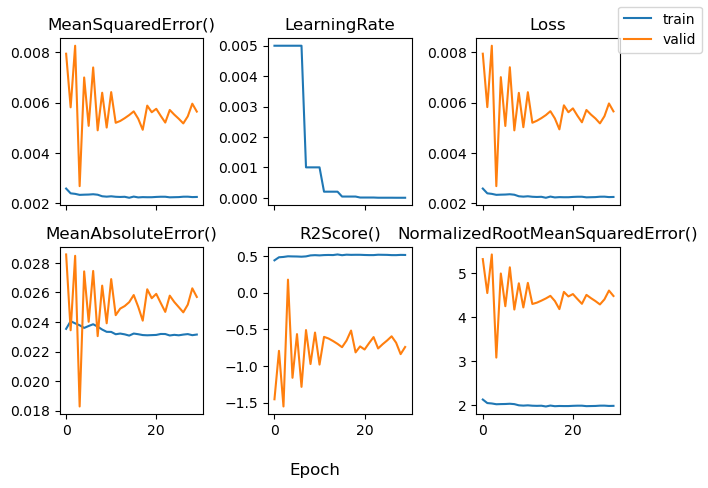

In [16]:
util.plot.plot_all_scalars_in_run(f"logs/{model_name}/history")

In [19]:
from tqdm.autonotebook import tqdm
# Run on test metrics
test_metrics = util.training.get_regr_metrics()

model.eval()
with torch.no_grad():
    for (X, y) in tqdm(test_dl, leave=False):
        y_hat = model(X)
        for metric in test_metrics:
            metric(y_hat.view(-1), y.view(-1))

for metric in test_metrics:
    print(f"{str(metric)}: {metric.compute():.5f}")

  0%|          | 0/781 [00:00<?, ?it/s]

NormalizedRootMeanSquaredError(): 2.09672
R2Score(): 0.34660
MeanAbsoluteError(): 0.02176
MeanSquaredError(): 0.00339
